In [74]:
import os

import imageio
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import qutip
import scipy
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [75]:
def animate_bloch(states, eig_states, name, duration=0.1, save_all=False):

    b = qutip.Bloch()
    b.vector_color = ["r"]
    # b.view = [-40,30]
    images = []

    try:
        length = len(states)
    except:
        length = 1
        states = [states]
    ## normalize colors to the length of data ##
    # nrm = mpl.colors.Normalize(0,length)
    # colors = cm.cool(nrm(range(length))) # options: cool, summer, winter, autumn etc.

    ## customize sphere properties ##
    # b.point_color = [colors[0]] # options: 'r', 'g', 'b' etc.
    b.point_marker = ["o"]
    b.point_size = [25]

    for i in range(length):
        b.clear()
        b.add_states(eig_states)
        b.add_states(states[i])
        b.add_states(states[: (i + 1)], "point")
        if save_all:
            b.save(dirc="sphere")  # saving images to tmp directory
            filename = "sphere/bloch_%01d.png" % i
        else:
            filename = "temp_file.png"
            b.save(filename)
        images.append(imageio.v2.imread(filename))
    imageio.mimsave(f"{name}.gif", images, duration=duration)

In [76]:
def bloch_vector_to_statevector(bloch_vector):
    # Unpack the Bloch vector
    x, y, z = bloch_vector

    # Calculate the norm of the Bloch vector
    r = np.sqrt(x**2 + y**2 + z**2)

    # Normalize the vector (if r is zero, return the ground state |0⟩)
    if r == 0:
        return qutip.basis(2, 0)  # The |0⟩ state

    # Normalize the Bloch vector
    x_norm = x / r
    y_norm = y / r
    z_norm = z / r

    # Calculate theta and phi
    theta = np.arccos(z_norm)  # Angle from z-axis
    phi = np.arctan2(y_norm, x_norm)  # Angle in x-y plane

    # Convert to the quantum state |ψ⟩
    statevector = np.cos(theta / 2) * qutip.basis(2, 0) + np.exp(1j * phi) * np.sin(
        theta / 2
    ) * qutip.basis(2, 1)

    return statevector

In [77]:
# Pauli matrices
sx = qutip.sigmax()
sy = qutip.sigmay()
sz = qutip.sigmaz()

# Exercise 29
Solve the above equations numerically and reconstruct the evolution of the Bloch state vector. Use initially $\omega_d = \omega$ and $g = \omega/1000$ and try to vary both. Start from various initial states, such as states $\lvert 0 \rangle$, $\lvert 1 \rangle$, $\lvert i \rangle$, $\lvert -i \rangle$, and see if they evolve into each other.

In [78]:
# Define parameters
omega = 2 * np.pi  # Natural frequency of the qubit
omega_d = omega  # Driving frequency, initially set to be resonant
g = omega / 1000  # Driving strength

In [79]:
# Define the time-dependent Hamiltonian
def H_t(t, args):
    omega_d = args["omega_d"]
    g = args["g"]
    return -0.5 * omega * sz - g * np.cos(omega_d * t) * sx

In [80]:
# Define different initial states to evolve
initial_states = {
    "|0>": qutip.basis(2, 0),  # Ground state
    "|1>": qutip.basis(2, 1),  # Excited state
    "|i>": (qutip.basis(2, 0) + 1j * qutip.basis(2, 1)).unit(),  # +i superposition
    "|-i>": (qutip.basis(2, 0) - 1j * qutip.basis(2, 1)).unit(),  # -i superposition
}

In [81]:
# Define time points for the evolution
tlist = np.linspace(0, 500, int(1e5))  # 500 oscillation periods

# Define solver parameters
args = {"omega_d": omega_d, "g": g}

In [82]:
results = {}
# Evolve each initial state and plot the results
for label, psi0 in initial_states.items():
    # Solve the time evolution
    result = qutip.mesolve(H_t, psi0, tlist, [], [sx, sy, sz], args=args)
    results[label] = result

In [83]:
def multi_state_expval_plot(results, args, stop=None):
    fig, ax = plt.subplots(2, 2, figsize=(15, 8))
    labels = list(initial_states.keys())
    fig.suptitle(
        f"Time Evolution ($g$ = {args['g']:.2f}, $\omega_d$ = {args['omega_d'] / (np.pi):.2f} $\pi$)"
    )

    for i in range(2):
        for j in range(2):
            label = labels[i + 2 * j]
            result = results[label]

            # Plot expectation values of X, Y, Z
            ax[i][j].plot(
                tlist[:stop], result.expect[0][:stop], label=r"$\langle X \rangle$"
            )
            ax[i][j].plot(
                tlist[:stop], result.expect[1][:stop], label=r"$\langle Y \rangle$"
            )
            ax[i][j].plot(
                tlist[:stop], result.expect[2][:stop], label=r"$\langle Z \rangle$"
            )
            ax[i][j].axhline(0, color="k", lw=0.5)
            ax[i][j].set_title(f"State {label}")
            ax[i][j].set_xlabel("Time [s]")
            ax[i][j].set_ylabel("Expectation values")
            ax[i][j].legend()
            ax[i][j].grid()

    plt.tight_layout()
    plt.show()

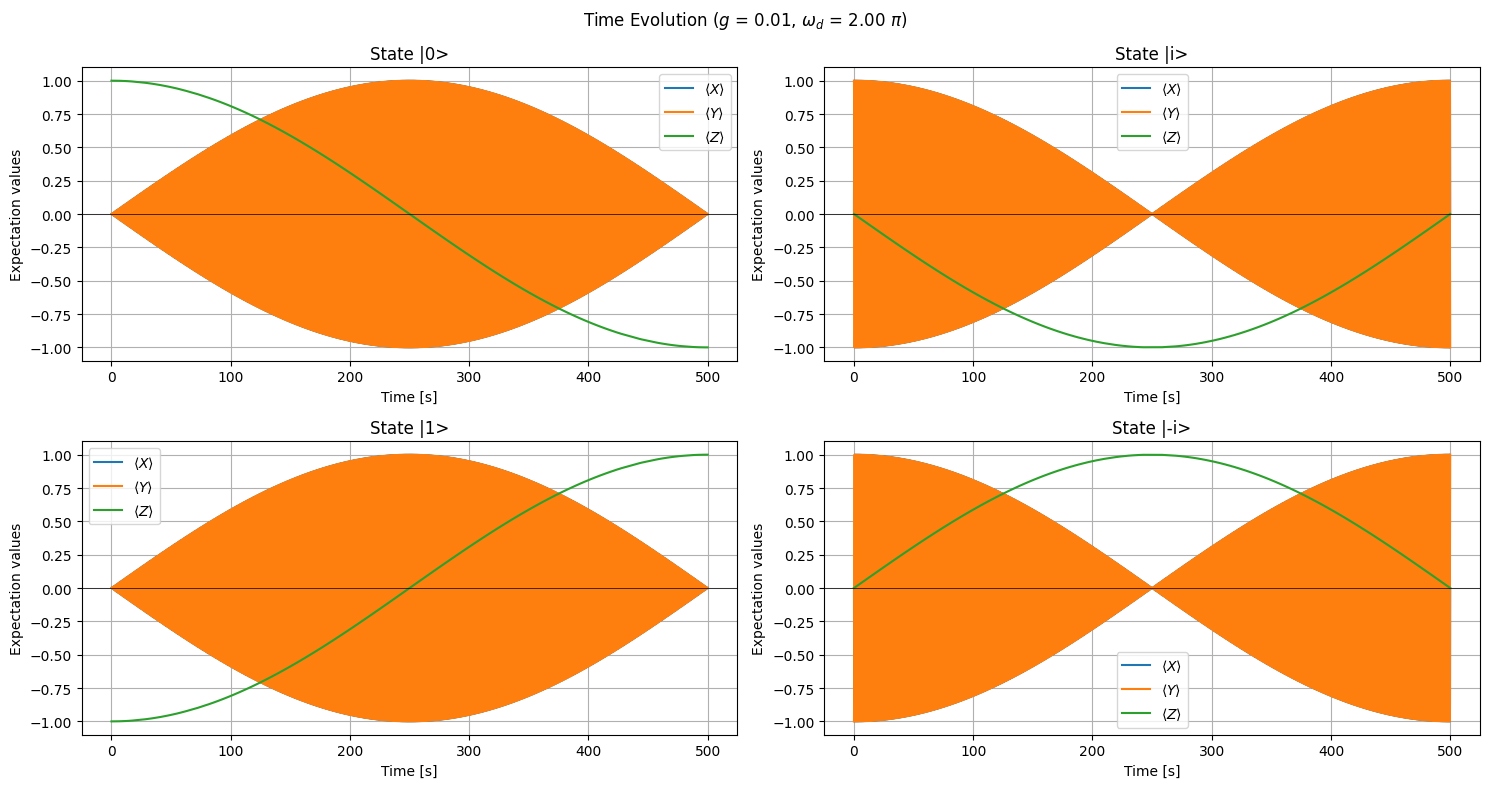

In [84]:
multi_state_expval_plot(results, args)

Although the above plots looks like having solid colored shapes, they are actually oscillations. To see this, Lets plot the expectation values over time for a small interval

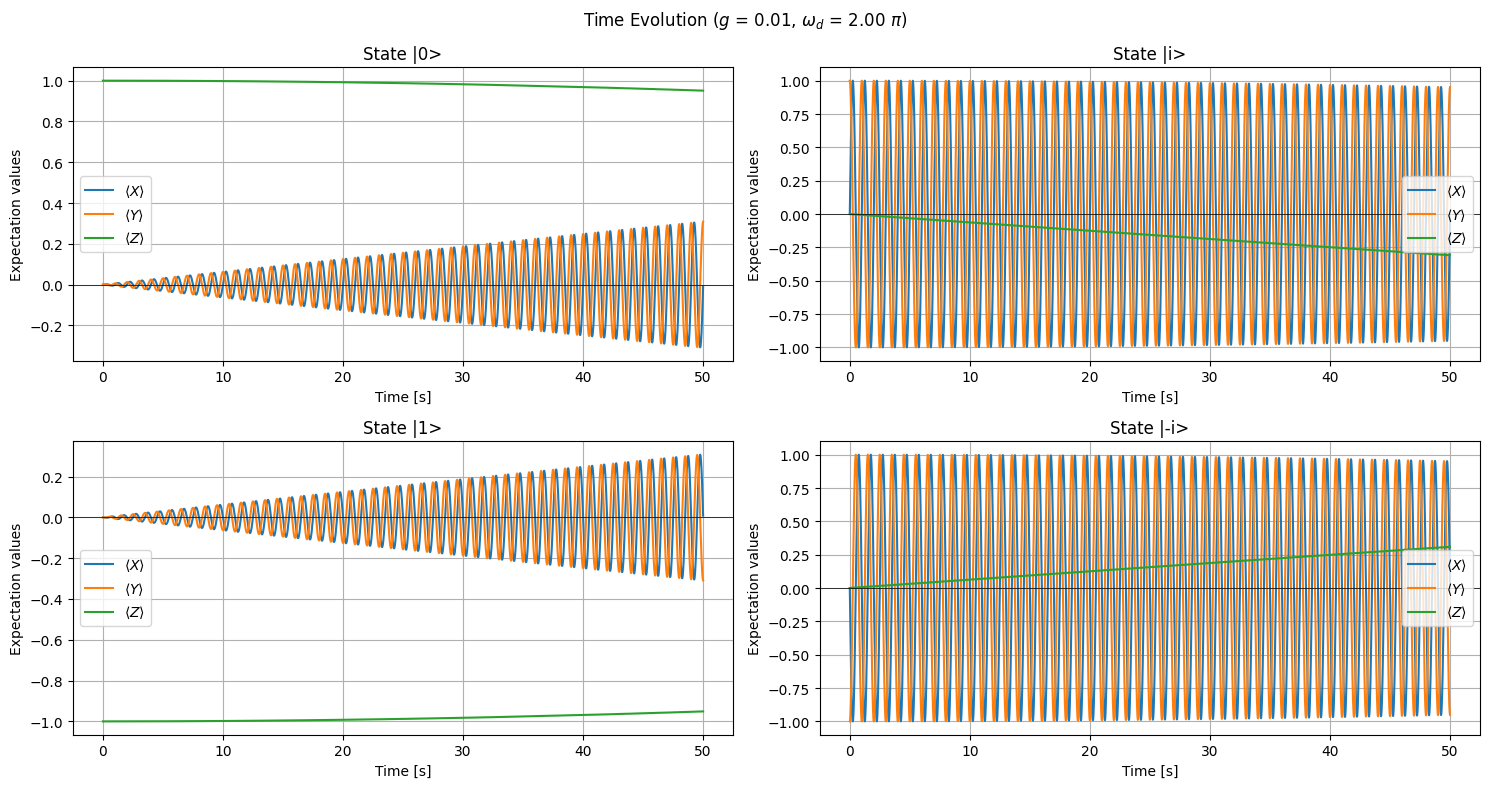

In [89]:
multi_state_expval_plot(results, args, int(1e4))

In [90]:
# Vary g and omega_d and observe the change
g_new = omega / 500  # Increase driving strength
omega_d_new = 1.01 * omega  # Detune the driving frequency

# Update solver parameters
args_new = {"omega_d": omega_d_new, "g": g_new}

results_new = {}
# Evolve each initial state and plot the results
for label, psi0 in initial_states.items():
    # Solve the time evolution
    result = qutip.mesolve(
        H_t,
        psi0,
        tlist,
        [],
        [sx, sy, sz],
        args=args_new,
        options=qutip.solver.Options(store_states=True),
    )
    results_new[label] = result

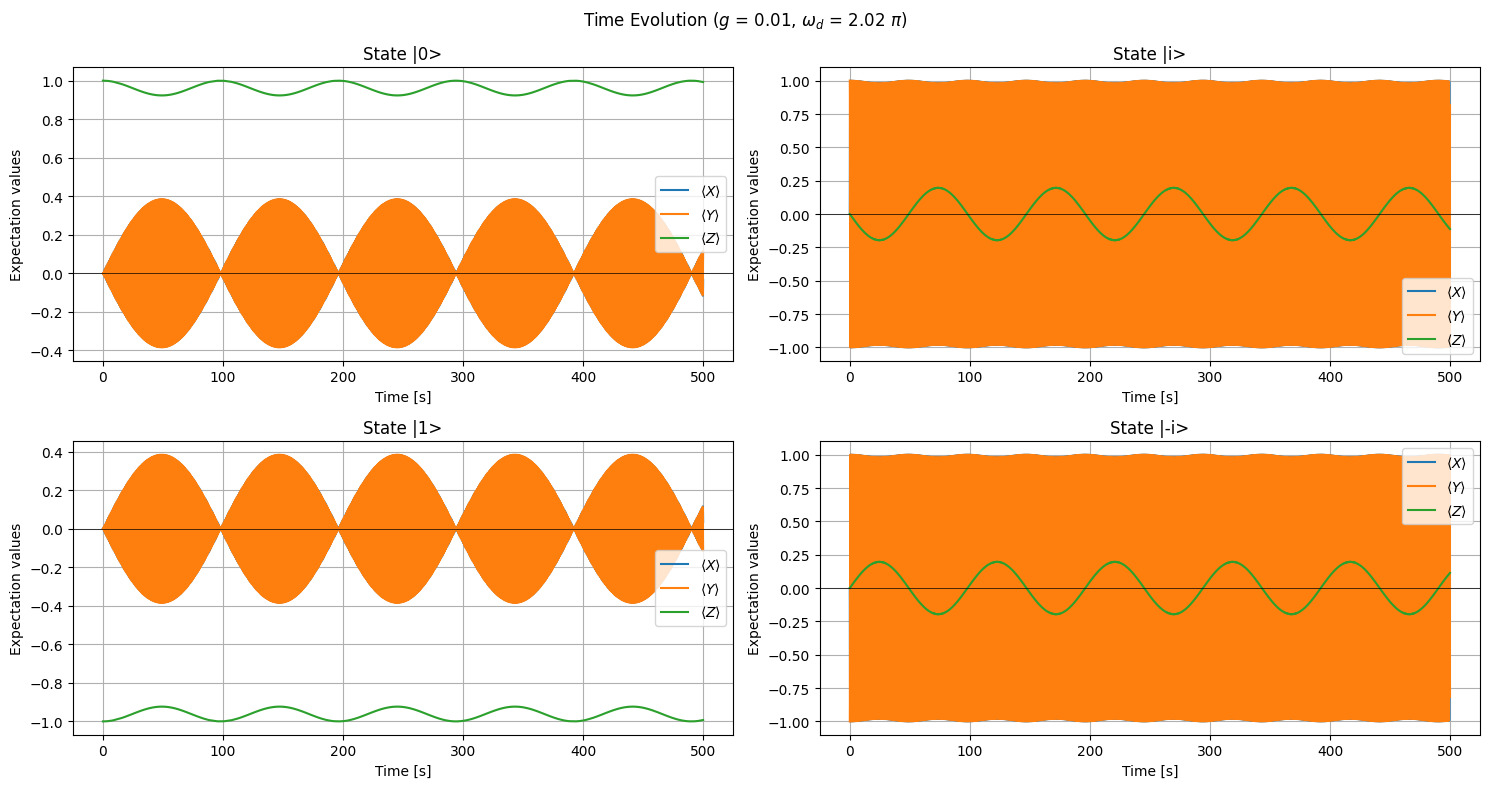

In [91]:
multi_state_expval_plot(results_new, args_new)

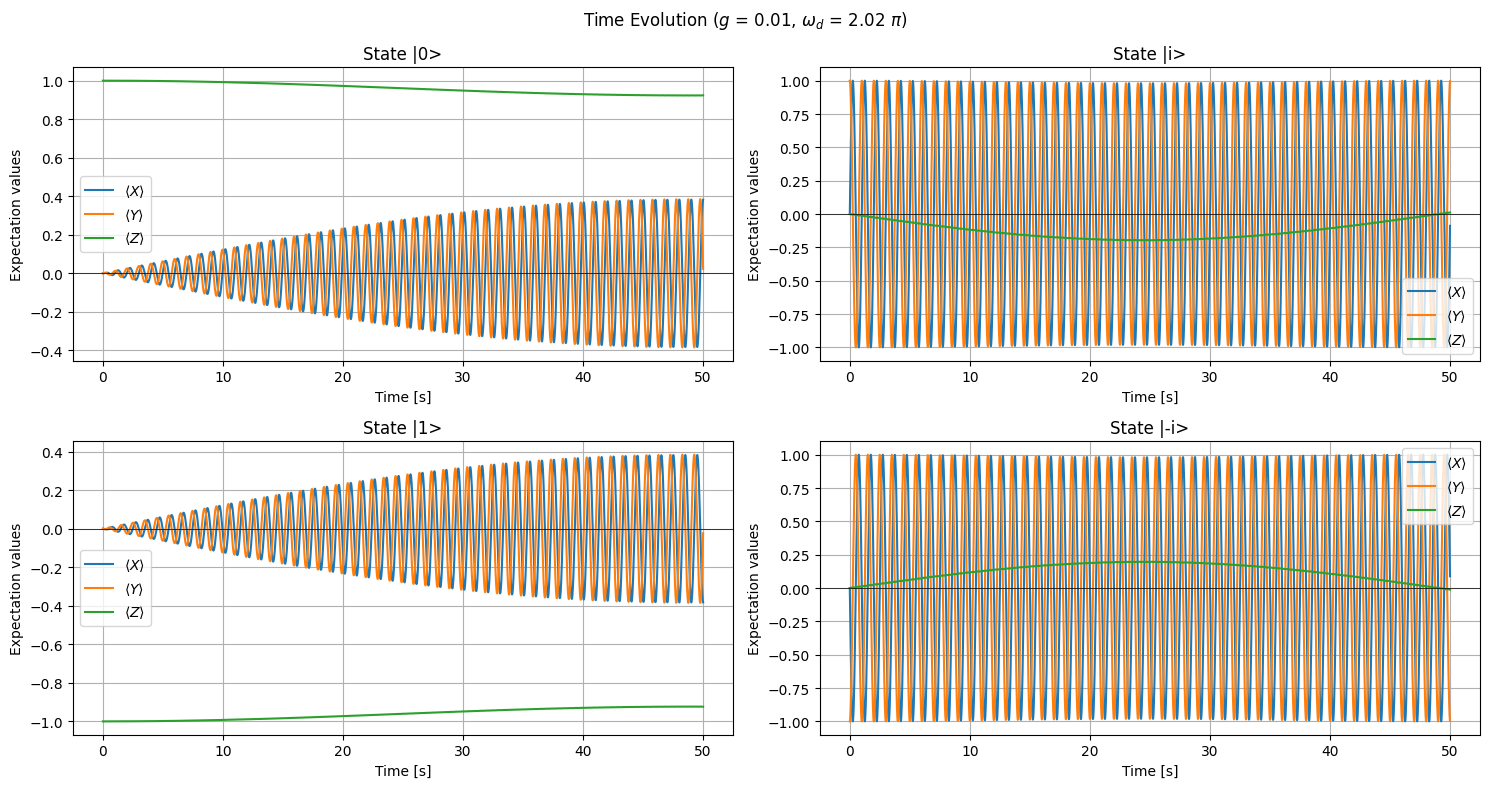

In [92]:
multi_state_expval_plot(results_new, args_new, int(1e4))

# Exercise 30
Apply the drive frame operator $\hat{U} = \exp(-i\omega_d t Z/2)$ to the obtained numerical solution and see how it simplifies again. The meaning of this transformation is that you are now rotating along the $Z$-axis with an angular frequency $\omega_d$.


In [93]:
def apply_unitary(state, time, omega_Z):
    U = (-1j * 0.5 * omega_Z * time * sz).expm()
    return U * state

In [94]:
class MyResult:
    def __init__(self):
        self.states = []
        self.expect = []
        self.times = []

In [95]:
def get_result_after_unitary(res, times, omega_Z):
    x_trans, y_trans, z_trans = [], [], []

    result_trans = MyResult()

    for t, state in zip(times, res.states):
        # Apply the unitary transformation to all states in the evolution
        state_trans = apply_unitary(state, t, omega_Z)

        # Extract the expectation values
        x_trans.append(qutip.expect(sx, state_trans))
        y_trans.append(qutip.expect(sy, state_trans))
        z_trans.append(qutip.expect(sz, state_trans))

    result_trans.states = res.states
    result_trans.expect = [x_trans, y_trans, z_trans]
    result_trans.times = res.times

    return result_trans

In [96]:
results_transformed = {}
for key, value in results_new.items():
    results_transformed[key] = get_result_after_unitary(
        value, tlist, args_new["omega_d"]
    )

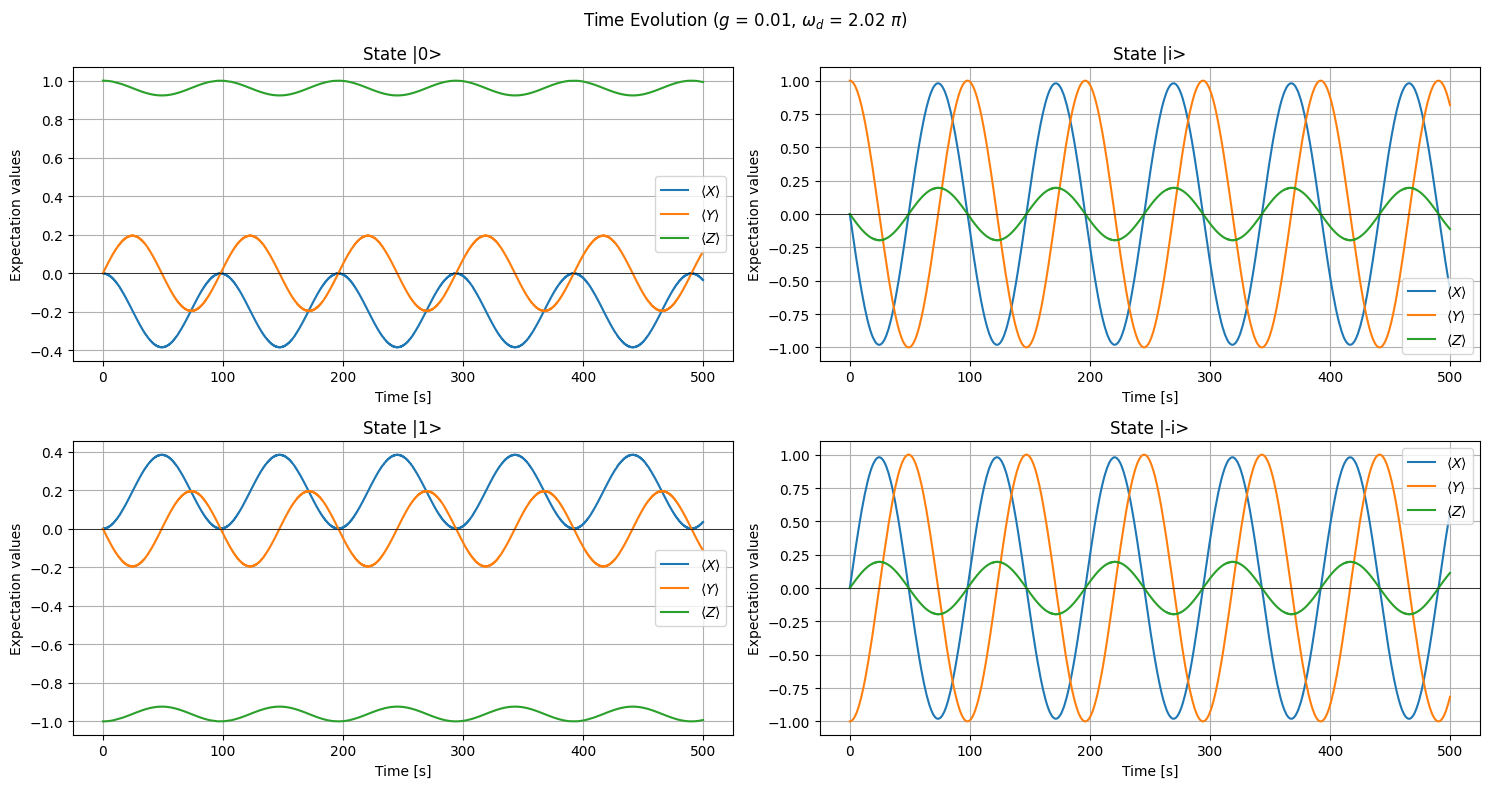

In [97]:
multi_state_expval_plot(results_transformed, args_new)

# Exercise 31, 32 and 33

Solved by hand in the document.

# Exercise 34 
Recover the rotation of the Bloch sphere vector in the lab frame by applying the $U^{-1}$ operator to the drive frame solution. Show the resulting trajectory on the Bloch sphere.


In [98]:
# Define parameters
omega_d = 2 * np.pi  # Driving frequency (resonant)
g = omega_d / 10  # Driving strength


# Define the time evolution in the drive frame
def H_drive_frame(t, args):
    return -0.5 * g * sx


# Define the inverse unitary transformation U^-1
def apply_inv_unitary(state, time, omega_Z):
    U = (1j * 0.5 * omega_Z * time * sz).expm()
    return U * state


# Define the initial state (start at |0>)
initial_state = qutip.basis(2, 0)

# Time points for evolution
tlist = np.linspace(0, 1 * (2 * np.pi / g), 500)  # 1 oscillation periods

# Evolve in the drive frame
result_drive = qutip.mesolve(
    H_drive_frame,
    initial_state,
    tlist,
    [],
    [sx, sy, sz],
    options=qutip.solver.Options(store_states=True),
)

In [99]:
# Apply inverse unitary to recover the state in the lab frame
x_lab, y_lab, z_lab = [], [], []
for t, state in zip(tlist, result_drive.states):
    # Apply U^-1 to the drive frame solution
    transformed_state = apply_inv_unitary(state, t, omega_d)
    x_lab.append(qutip.expect(sx, transformed_state))
    y_lab.append(qutip.expect(sy, transformed_state))
    z_lab.append(qutip.expect(sz, transformed_state))

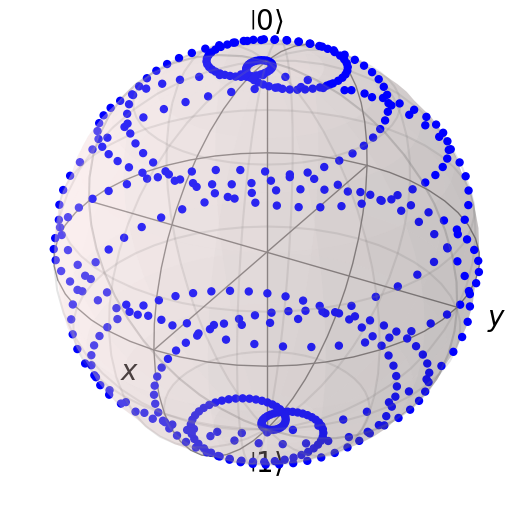

In [100]:
# Plot the trajectory on the Bloch sphere
b = qutip.Bloch()
b.add_points([x_lab, y_lab, z_lab])
b.show()

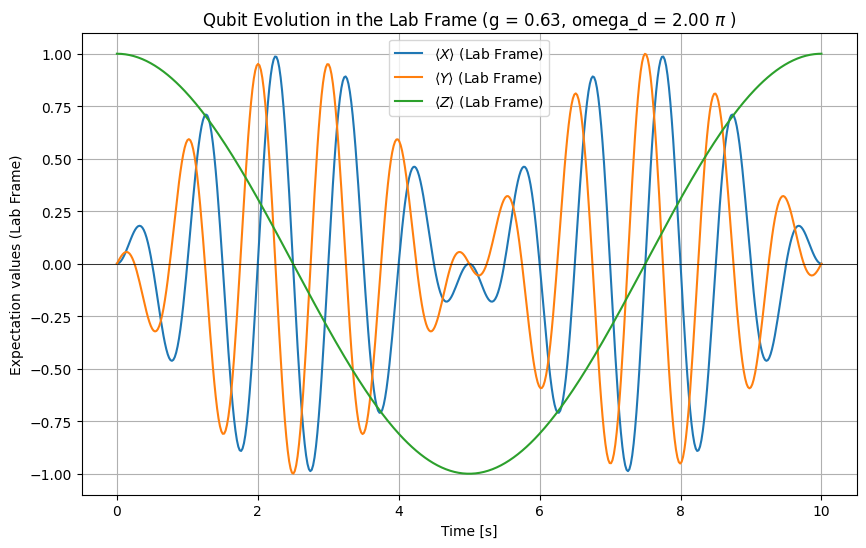

In [101]:
# Plot the expectation values as a function of time
plt.figure(figsize=(10, 6))
plt.plot(tlist, x_lab, label=r"$\langle X \rangle$ (Lab Frame)")
plt.plot(tlist, y_lab, label=r"$\langle Y \rangle$ (Lab Frame)")
plt.plot(tlist, z_lab, label=r"$\langle Z \rangle$ (Lab Frame)")
plt.axhline(0, color="k", lw=0.5)
plt.xlabel("Time [s]")
plt.ylabel("Expectation values (Lab Frame)")
plt.legend()
plt.title(
    f"Qubit Evolution in the Lab Frame (g = {g:.2f}, omega_d = {omega_d / (np.pi):.2f} $\pi$ )"
)
plt.grid()
plt.show()

# Exercise 35
Show the qubit state vector evolution along the Bloch sphere (in the drive frame), in case $\omega - \omega_d = g$, $\omega - \omega_g = 10g$, and $\omega - \omega_g = 100g$. Do you see why highly off-resonant drive of the qubit does not matter?


**Hamiltonian in the Drive Frame**: The drive frame Hamiltonian (with detuning $\delta = \omega - \omega_d$) is:

$\hat{H}_{\text{drive frame}} = -\frac{\delta}{2} \hat{Z} - \frac{g}{2} \hat{X}$

where $\delta = \omega - \omega_d$ is the detuning between the qubit's natural frequency and the drive frequency.


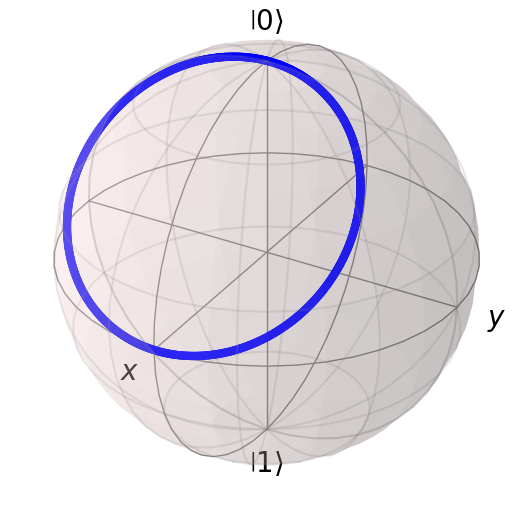

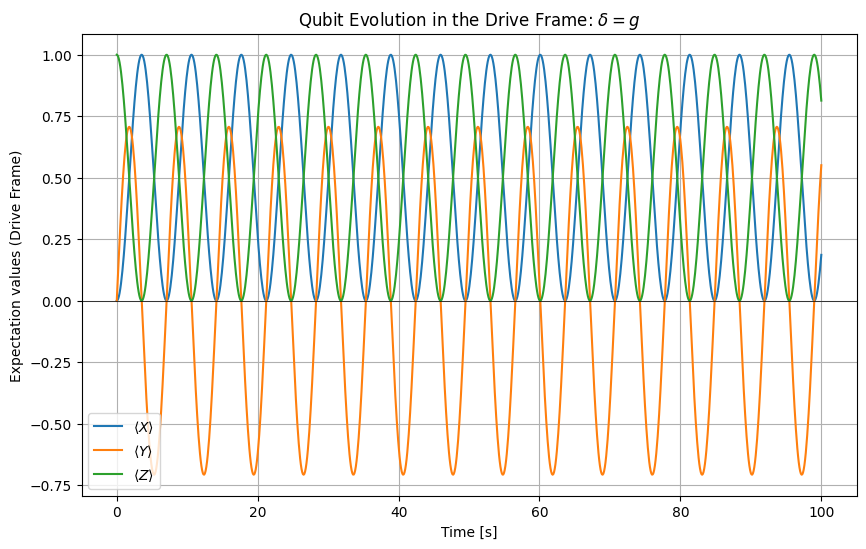

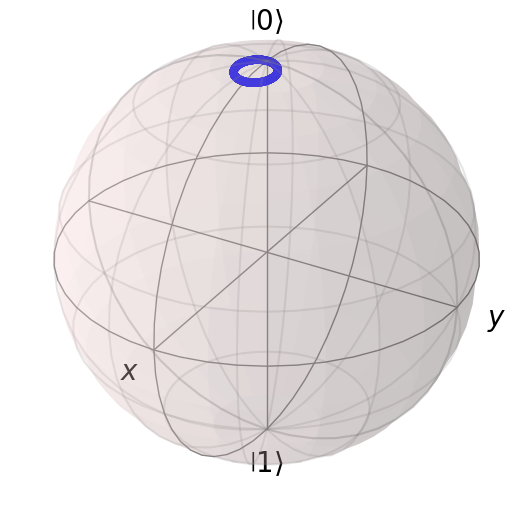

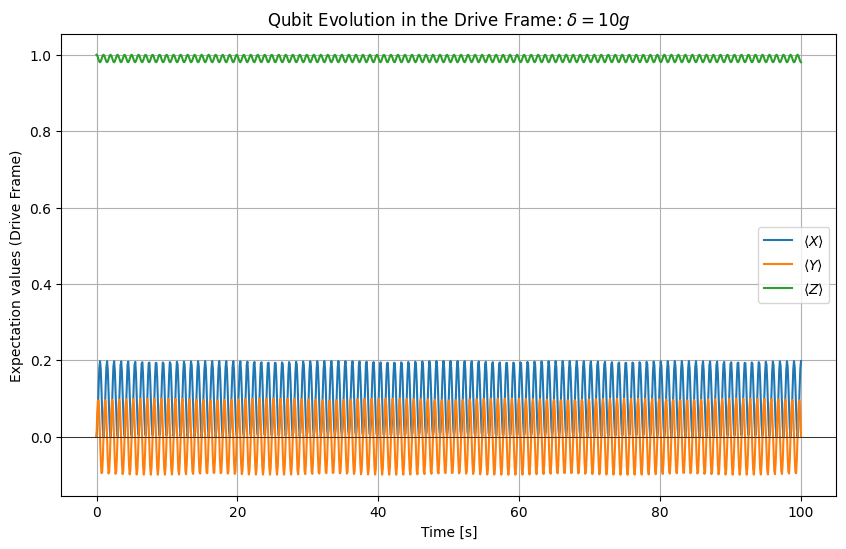

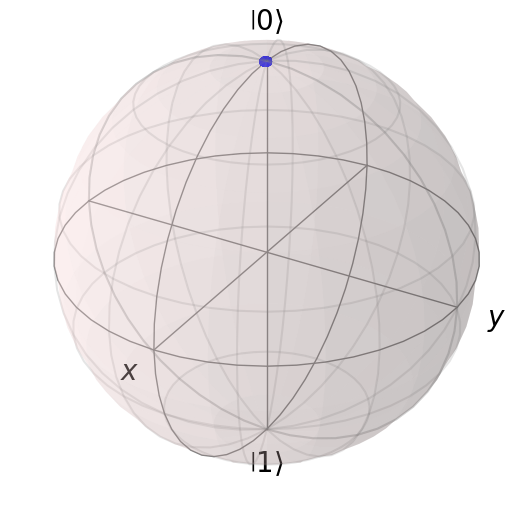

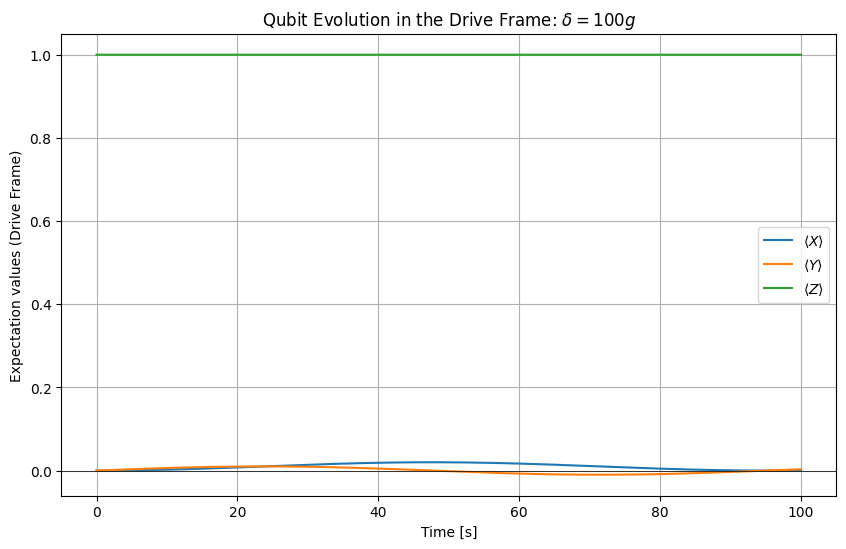

In [102]:
# Define parameters
g = 2 * np.pi / 10  # Driving strength (arbitrary choice for g)


# Define the drive frame Hamiltonian with detuning delta
def H_drive_frame(t, args):
    delta = args["delta"]
    g = args["g"]
    return -0.5 * delta * sz - 0.5 * g * sx


# Define the initial state (start at |0>)
initial_state = qutip.basis(2, 0)

# Time points for evolution
tlist = np.linspace(0, 10 * (2 * np.pi / g), 1000)  # 10 oscillation periods

# Different detuning values to simulate
detunings = [g, 10 * g, 100 * g]
labels = [r"$\delta = g$", r"$\delta = 10g$", r"$\delta = 100g$"]

# Plot the evolution for each detuning value
for delta, label in zip(detunings, labels):
    # Define solver arguments
    args = {"delta": delta, "g": g}

    # Solve the time evolution in the drive frame
    result_drive = qutip.mesolve(
        H_drive_frame, initial_state, tlist, [], [sx, sy, sz], args=args
    )

    # Extract expectation values for X, Y, Z components
    x_drive = result_drive.expect[0]
    y_drive = result_drive.expect[1]
    z_drive = result_drive.expect[2]

    # Plot the trajectory on the Bloch sphere
    b = qutip.Bloch()
    b.add_points([x_drive, y_drive, z_drive])
    b.title = f"Drive Frame Evolution: {label}"
    b.show()

    # Plot the expectation values as a function of time
    plt.figure(figsize=(10, 6))
    plt.plot(tlist, x_drive, label=r"$\langle X \rangle$")
    plt.plot(tlist, y_drive, label=r"$\langle Y \rangle$")
    plt.plot(tlist, z_drive, label=r"$\langle Z \rangle$")
    plt.axhline(0, color="k", lw=0.5)
    plt.xlabel("Time [s]")
    plt.ylabel("Expectation values (Drive Frame)")
    plt.legend()
    plt.title(f"Qubit Evolution in the Drive Frame: {label}")
    plt.grid()
    plt.show()

**Near Resonance $\delta = g$**:

The qubit undergoes significant rotation in the Bloch sphere. This case represents near-resonance, where the drive strongly influences the qubit's dynamics.

**Moderate Off-Resonance $\delta = 10g$**:

The qubit's evolution becomes much slower. The drive is less effective in causing a significant rotation of the qubit state.

**Highly Off-Resonant $\delta = 100g$**:

The qubit remains almost stationary in the Bloch sphere. The drive frequency is so far from the qubit's natural frequency that the drive has negligible effect.

**Why highly off-resonant drive of the qubit does not matter?**

When the detuning $\delta$ is much larger than the drive strength $g$, the qubit experiences very little evolution. The reason is that when $\delta \gg g$, the qubit's natural frequency is so far from the drive frequency that the qubit hardly "feels" the drive. This leads to negligible interaction between the qubit and the driving field, and the qubit remains close to its initial state.

# Exercise 36 
Make a density plot of $\langle Z \rangle(t)$ as a function of $\omega - \omega_d$, for $g = 1$, $\omega - \omega_d$ between $-3$ and $3$, and choose a range for $t$ such that several oscillations are seen. This is often called the "Chevron plot".


In [103]:
# Define parameters
g = 1  # Driving strength


# Define the drive frame Hamiltonian with detuning delta
def H_drive_frame(t, args):
    delta = args["delta"]
    g = args["g"]
    return -0.5 * delta * sz - 0.5 * g * sx


# Define the initial state (start at |0>)
initial_state = qutip.basis(2, 0)

# Time points for evolution
tlist = np.linspace(
    0, 10 * (2 * np.pi / g), 100
)  # Enough time for several oscillations

# Range of detuning values (delta = omega - omega_d)
delta_values = np.linspace(-3 * g, 3 * g, 100)

# Create a 2D array to store ⟨Z⟩(t) for each detuning
Z_expect = np.zeros((len(delta_values), len(tlist)))

# Solve for each detuning value and store ⟨Z⟩(t)
for idx, delta in enumerate(delta_values):
    args = {"delta": delta, "g": g}
    result = qutip.mesolve(H_drive_frame, initial_state, tlist, [], [sz], args=args)
    Z_expect[idx, :] = result.expect[0]  # Store ⟨Z⟩(t)

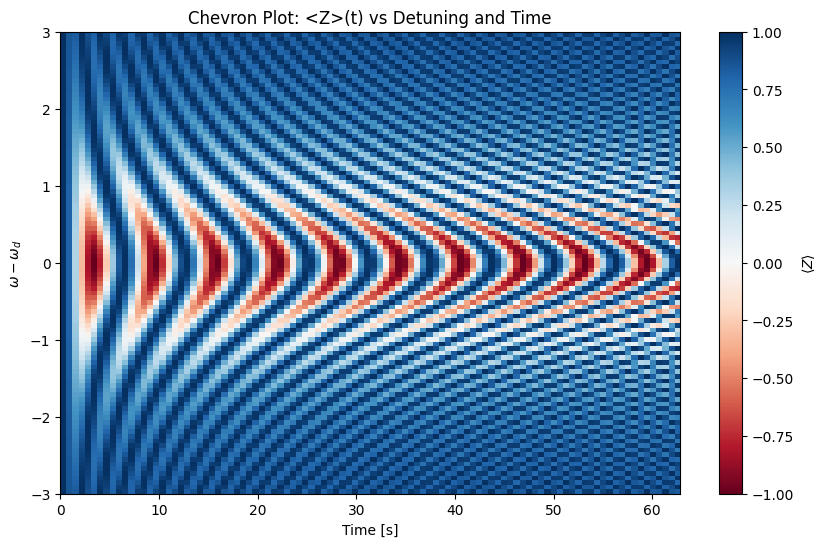

In [104]:
# Create the density plot (Chevron plot)
plt.figure(figsize=(10, 6))
plt.imshow(
    Z_expect,
    aspect="auto",
    origin="lower",
    extent=[tlist[0], tlist[-1], delta_values[0], delta_values[-1]],
    cmap="RdBu",
    vmin=-1,
    vmax=1,
)
plt.colorbar(label=r"$\langle Z \rangle$")
plt.xlabel("Time [s]")
plt.ylabel(r"$\omega - \omega_d$")
plt.title("Chevron Plot: <Z>(t) vs Detuning and Time")
plt.show()

In [53]:
X, Y = np.meshgrid(tlist, delta_values)

In [54]:
# precede the number with zeros, creating a thong of a certain length
def makeIndexOfLength(index, length):
    indexStr = str(index)
    return "0" * (length - len(indexStr)) + indexStr

In [56]:
OUTPUT_DIR = "expval_z_t"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for angle in tqdm(range(0, 180)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(
        X,
        Y,
        Z_expect,
        rstride=1,
        cstride=1,
        cmap="RdBu",
        linewidth=0,
        antialiased=False,
        alpha=0.6,
    )
    ax.set_zlim(-1, 1)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("$\omega - \omega_d$")
    ax.set_zlabel("<Z>(t)")
    ax.view_init(30 + (90 - angle) / 5, 45 + angle * 2)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    plt.savefig("./" + OUTPUT_DIR + "/" + makeIndexOfLength(angle, 3) + ".png")
    plt.close()

100%|█████████████████████████████████████████| 180/180 [01:40<00:00,  1.80it/s]


Below is a 3d visualization of the above density plot. If not rendered, can be found [here](https://github.com/Gopal-Dahale/qmnp/tree/main/hw1/p2#exercise-36).

<div align="center">
<img width="" src="expval_z_t.gif" /><br>
</div>

# Exercise 37
Do the same plot as above but this time as a function of $g$ for $\omega = \omega_d$. Also plot the frequency of oscillations as a function of $g$.


In [115]:
# Define parameters
omega_d = 2 * np.pi  # Resonant drive frequency (omega = omega_d)
g_range = np.linspace(-3, 3, 200)  # Range of driving strengths (g)
tlist = np.linspace(0, 20 * np.pi, 1000)  # Time points to observe several oscillations


# Define the drive frame Hamiltonian (for resonant case omega = omega_d)
def H_drive_frame(t, args):
    g = args["g"]
    return -0.5 * g * sx


# Define the initial state (start at |0>)
initial_state = qutip.basis(2, 0)

# Initialize an array to store ⟨Z⟩(t) values for each driving strength g
z_expectation_values = np.zeros((len(g_range), len(tlist)))

# Iterate over the driving strengths g
for idx, g in enumerate(g_range):
    # Define solver arguments
    args = {"g": g}

    # Solve the time evolution in the drive frame for each driving strength
    result = qutip.mesolve(H_drive_frame, initial_state, tlist, [], [sz], args=args)

    # Store the expectation values of ⟨Z⟩(t)
    z_expectation_values[idx, :] = result.expect[0]

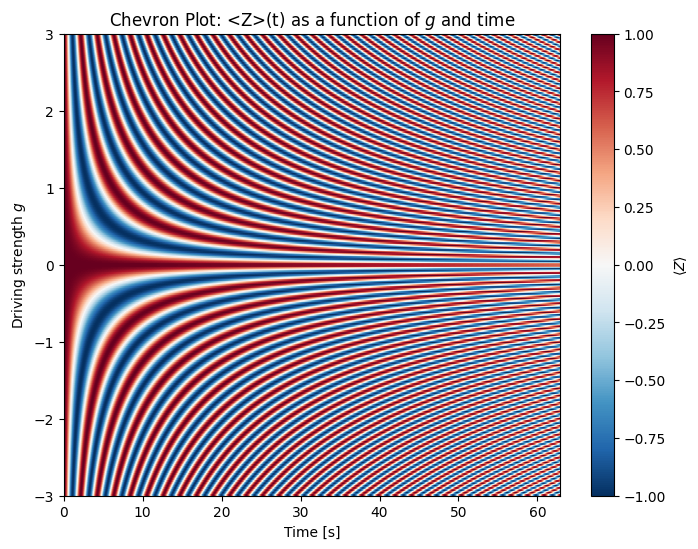

In [116]:
# Generate the density plot (Chevron plot) as a function of g
plt.figure(figsize=(8, 6))
plt.imshow(
    z_expectation_values,
    extent=[tlist[0], tlist[-1], g_range[0], g_range[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)
plt.colorbar(label=r"$\langle Z \rangle$")
plt.xlabel("Time [s]")
plt.ylabel("Driving strength $g$")
plt.title("Chevron Plot: <Z>(t) as a function of $g$ and time")
plt.show()

We can animate for individual values of $g$

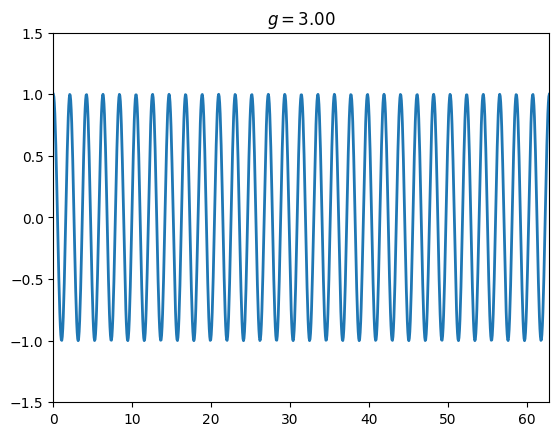

In [146]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = plt.axes(xlim=(tlist.min(), tlist.max()), ylim=(-1.5, 1.5))
(line,) = ax.plot([], [], lw=2)


def init():
    line.set_data([], [])
    return (line,)


def animate(i):
    x = tlist
    y = z_expectation_values[i]
    line.set_data(x, y)
    ax.set_title(f"$g = {g_range[i]:.2f}$")
    return (line,)


anim = FuncAnimation(fig, animate, init_func=init, frames=200, interval=100, blit=True)


anim.save("sine_wave.gif", writer="imagemagick")

The animation can be found [here](https://github.com/Gopal-Dahale/qmnp/tree/main/hw1/p2#exercise-37).
<div align="center">
<img width="" src="sine_wave.gif" /><br>
</div>

Solving by hand gives us the result that the $\langle Z \rangle(t) = \cos(gt)$, so the frequency of oscillations is $g / 2 \pi$. To find the frequencies in python, we can use the fourier transform and compare the results with the values obtained from the formula.

In [142]:
oscillation_frequencies = np.zeros(len(g_range))

for idx, g in enumerate(g_range):
    y_fft = np.fft.fft(z_expectation_values[idx])  # FFT of the signal
    frequencies = np.fft.fftfreq(
        len(tlist), tlist[1] - tlist[0]
    )  # Corresponding frequencies
    idx_dominant = np.argmax(np.abs(y_fft))  # Index of the dominant frequency
    dominant_frequency = abs(frequencies[idx_dominant])
    oscillation_frequencies[idx] = dominant_frequency

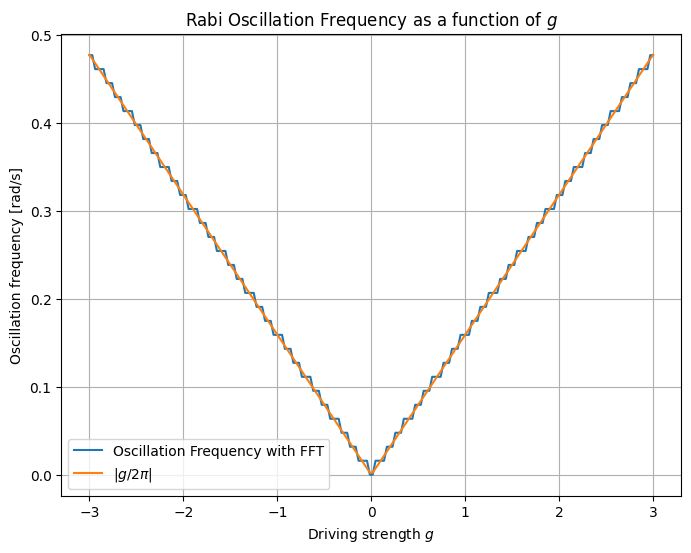

In [148]:
plt.figure(figsize=(8, 6))
plt.plot(g_range, oscillation_frequencies, label="Oscillation Frequency with FFT")
plt.plot(g_range, np.abs(g_range / (2 * np.pi)), label="$|g/2\pi|$")
plt.xlabel("Driving strength $g$")
plt.ylabel("Oscillation frequency [rad/s]")
plt.title("Rabi Oscillation Frequency as a function of $g$")
plt.grid(True)
plt.legend()
plt.show()